



# 📊 Data Cleaning and Analysis of Notifiable Disease Reports (2014–2017)


The main purpose of this project is to get familiar with processes of constructing and using a data warehouse. There are two sections: the first focuses on simple data loading and cleaning with simple data, and the second focuses on more complex data. In both cases, we will use publicly available datasets focused in the healthcare domain.

This project simulates a real-world ETL (Extract, Transform, Load) process using corrupted public health datasets from Nova Scotia's Open Data Portal. The notebook demonstrates:

## 📁 Table of Contents
### Sections-1 (Data cleaning and ETL)
1. [Library Installation and Setup](#library-setup)
2. [Data Loading](#data-loading)
3. [Sorting and Inspection](#data-sorting)
4. [Duplicate Handling](#duplicates)
5. [Missing Data Treatment](#missing-values)
6. [Out-of-Bounds Data Correction](#out-of-bounds)
7. [Internal and cross-dataset consistency checks](#Data-consistency)
8. [data visualization and transformation](#Data-visualization)
### Sections-2(Data imputation, reduction, and basic analysis)
9. [Data Loading, Impute missing data & Preprocessing](#Data-LMP)
10. [Dimensionality Reduction (PCA)](#Data-LMP)
11. [Distribution Fitting](#Data-DF)
12. [Entropy Calculation](#Data-Entropy)
13. [Correlation Analysis and Visualization](#Data-Correction-Visualization)


In [32]:
# 1.Library Installation and Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from fitter import Fitter, get_common_distributions

## Section 1 - Data cleaning and ETL

A [Notifiable disease](https://en.wikipedia.org/wiki/Notifiable_disease#Canada) is any disease that, by law, must be reported to government authorities. Aggregating data on these diseases allows the authorities to monitor their development, and provides early warning of possible outbreaks. The [Canadian Notifiable Disease Surveillance System](https://diseases.canada.ca/notifiable/) is a searchable database tool provided by the Public Health Agency of Canada. 

In this Section, we will practice cleaning some small, simple datasets.

### Dataset

The data for this section come from [Nova Scotia's Open Data Portal](https://data.novascotia.ca/) under the [Nova Scotia Open Government Licence](http://novascotia.ca/opendata/licence.asp). Specifically:

1. [Notifiable Diseases Counts and Rates By Zone 2014-2017](https://data.novascotia.ca/Health-and-Wellness/Notifiable-Diseases-Counts-and-Rates-By-Zone-2014-/36ek-n7n8), and
2. [Notifiable Diseases Counts and Rates By Sex 2014-2017](https://data.novascotia.ca/Health-and-Wellness/Notifiable-Diseases-Counts-and-Rates-By-Sex-2014-2/hgpa-vixp)

The two files are in the [CSV](https://www.w3schools.com/python/pandas/pandas_csv.asp) file format, with a single header row and the following fields (Zone and Sex only appear in their respective file):

| Field                       | Type      | Description |
|-----------------------------|-----------|-------------|
| Zone                        | Text      | One of four non-overlapping regions, or the aggregate 'Nova Scotia'      |
| Sex                         | Text      | Traditional binary labels, or the aggregate 'All'       |
| Year                        | Int       | The year in the Common Era |
| Disease                     | Text      | The name of the disease. Additional information on the diseases can be found [here](https://novascotia.ca/dhw/cdpc/cdc/). |
| Number of Cases             | Int       | The number of cases in the indicated region, for the indicated year |
| Rate per 100,000 population | Float     | The rate per 100,000 population in the indicated region, for the indicated year |


Public government data are less likely to contain errors that require cleaning or correction, so we have artificially corrupted the data for this project using a Python script. Specifically, we have made the following corruptions:

1. **Removal**. We have randomly removed data in individual cells. Fields may be empty, have some indicative label such as 'Null', or some other corruption indicating deletion. To mimic real-world scenarios, we cannot tell you what all of these corruptions may be.
2. **Range errors**. We have given some numeric data impossibly small values.
3. **Spelling**. We have introduced spelling mistakes using the [corrupted-text](https://pypi.org/project/corrupted-text/) library to text fields.
4. **Duplicates**. We have randomly repeated some rows
5. **Shuffle**. We have randomly shuffled rows subsequent to the above corruptions.

### Tasks

Our tasks in this section are to clean the data, perform simple 'sanity checks', and display some simple visualizations. This is essentially a simplified view into an ETL process. You can use the clean data provided directly by the Nova Scotia government at the links above to validate your work, but your code must work assuming you don't have acss to the clean gold standard versions. Also note that we are fortunate that these data have, essentially, error-correcting codes built in, since 'All' data should be the sum of Male and Female data, and 'Nova Scotia' data should be the sum of all the individual regions.

Complete each of the code cells below according to the instructions in the comments.



In [35]:
!pip install pandas

In [36]:
!pip install numpy

In [37]:
!pip install scikit-learn

In [38]:
!pip install Fitter

In [39]:
!pip install matplotlib

In [40]:
!pip install stats

In [41]:
!pip install entropy

In [42]:
!pip install seaborn

In [43]:
# ------------------
# 2. Data Loading
# ------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

urlSex  = 'https://dalu-my.sharepoint.com/:x:/r/personal/fr591304_dal_ca/Documents/Dal/Teaching/CSCI4144%20-%20Data%20Warehousing/2025/Assignments/A1/data/Notifiable_Diseases_Counts_and_Rates_By_Sex_2014-2017.corrupt.csv?d=wa891a4e2dd374647ba98954c4d96922a&csf=1&web=1&e=oE3hsK'
urlZone = 'https://dalu-my.sharepoint.com/:x:/r/personal/fr591304_dal_ca/Documents/Dal/Teaching/CSCI4144%20-%20Data%20Warehousing/2025/Assignments/A1/data/Notifiable_Diseases_Counts_and_Rates_By_Zone_2014-2017.corrupt.csv?d=w6797e27e89fe4e21b6e8fc1e01e6f7b1&csf=1&web=1&e=stbkkc'

# Load corrupted datasets
doc_sex = pd.read_csv('Notifiable_Diseases_Counts_and_Rates_By_Sex_2014-2017.corrupt.csv')
doc_zone = pd.read_csv('Notifiable_Diseases_Counts_and_Rates_By_Zone_2014-2017.corrupt.csv')

# Preview the loaded data
print("First few rows of doc_sex:")
print(doc_sex.head())

print("\nFirst few rows of doc_zone:")
print(doc_zone.head())


First few rows of doc_sex:
   Unnamed: 0     Sex    Year                 Disease  Number of Cases  \
0           0  Female  2014.0  Listeriosis - Invasive              3.0   
1           1     All  2017.0           Salmonellosis            171.0   
2           2    Male  2014.0                 Typhoid              0.0   
3           3    Male  2015.0            Tuberculosis              5.0   
4           4     All  2014.0                 Rubella              0.0   

   Rate per 100,000 population  
0                          0.6  
1                         17.9  
2                          0.0  
3                          1.1  
4                          0.0  

First few rows of doc_zone:
   Unnamed: 0         Zone    Year                              Disease  \
0           0     Northern  2014.0                              Malaria   
1           1      Western  2017.0  Creutzfeldt-Jakob Disease - Classic   
2           2  Nova Scotia  2014.0               Listeriosis - Invasive   
3

In [44]:
# ------------------
# 3. Sorting and Inspection
# ------------------

doc_sex_sorted = doc_sex.sort_values(by=["Year", "Disease", "Sex"])
doc_zone_sorted = doc_zone.sort_values(by=["Year", "Disease", "Zone"])


#print the two sorted Pandas DataFrames
print("\nSorted doc_sex:")
print(doc_sex_sorted.head())

print("\nSorted doc_zone:")
print(doc_zone_sorted.head())


Sorted doc_sex:
     Unnamed: 0     Sex    Year                              Disease  \
275         275     All  2014.0  Acquired Immune Deficiency Syndrome   
98           98  Female  2014.0  Acquired Immune Deficiency Syndrome   
446         446    Male  2014.0  Acquired Immune Deficiency Syndrome   
215         215     All  2014.0              Acute Flaccid Paralysis   
492         492  Female  2014.0              Acute Flaccid Paralysis   

     Number of Cases  Rate per 100,000 population  
275              2.0                          0.2  
98               0.0                          0.0  
446              2.0                          0.4  
215              1.0                          0.1  
492              1.0                          0.2  

Sorted doc_zone:
     Unnamed: 0         Zone    Year                              Disease  \
500         500      Central  2014.0  Acquired Immune Deficiency Syndrome   
181         181      Eastern  2014.0  Acquired Immune Deficiency S

In [45]:
# ----------------------
# 4. Duplicate Handling
# ----------------------

duplicated_sex = doc_sex[doc_sex.duplicated(subset=['Sex', 'Year', 'Disease', 'Number of Cases', 'Rate per 100,000 population'], keep=False)]
duplicated_zone = doc_zone[doc_zone.duplicated(subset=['Zone', 'Year', 'Disease', 'Number of Cases', 'Rate per 100,000 population'], keep=False)]

# Identify duplicates
print("Duplicated rows in doc_sex:")
for index, row in duplicated_sex.iterrows():
    print(f"Row {index}: {row.to_dict()}")

print("\nDuplicated rows in doc_zone:")
for index, row in duplicated_zone.iterrows():
    print(f"Row {index}: {row.to_dict()}")

# for each DataFrame, print a list of row indices for all duplicates except the first. 
#        E.g., if row 52 is a duplicate of row 51, and row 201 is a duplicate of row 200, 
#              print [52,201]

duplicates_sex_indices = doc_sex[doc_sex.duplicated(subset=['Sex', 'Year', 'Disease', 'Number of Cases', 'Rate per 100,000 population'], keep='first')].index.tolist()
duplicates_zone_indices = doc_zone[doc_zone.duplicated(subset=['Zone', 'Year', 'Disease', 'Number of Cases', 'Rate per 100,000 population'], keep='first')].index.tolist()

print("\nRow indices of duplicates in doc_sex (except first occurrences):", duplicates_sex_indices)
print("Row indices of duplicates in doc_zone (except first occurrences):", duplicates_zone_indices)


# Remove duplicates
doc_sex_cleaned = doc_sex.drop_duplicates(subset=['Sex', 'Year', 'Disease', 'Number of Cases', 'Rate per 100,000 population'], keep='first')
doc_zone_cleaned = doc_zone.drop_duplicates(subset=['Zone', 'Year', 'Disease', 'Number of Cases', 'Rate per 100,000 population'], keep='first')

print("\nDuplicates have been removed from both doc_sex and doc_zone.")

Duplicated rows in doc_sex:
Row 57: {'Unnamed: 0': 57, 'Sex': 'All', 'Year': 2016.0, 'Disease': 'Legionellosis', 'Number of Cases': 1.0, 'Rate per 100,000 population': 0.1}
Row 112: {'Unnamed: 0': 112, 'Sex': 'All', 'Year': 2014.0, 'Disease': 'Toxoplasmosis', 'Number of Cases': 3.0, 'Rate per 100,000 population': 0.3}
Row 190: {'Unnamed: 0': 190, 'Sex': 'All', 'Year': 2014.0, 'Disease': 'Toxoplasmosis', 'Number of Cases': 3.0, 'Rate per 100,000 population': 0.3}
Row 207: {'Unnamed: 0': 207, 'Sex': 'All', 'Year': 2016.0, 'Disease': 'Legionellosis', 'Number of Cases': 1.0, 'Rate per 100,000 population': 0.1}
Row 221: {'Unnamed: 0': 221, 'Sex': 'Female', 'Year': 2016.0, 'Disease': 'Cyclosporiasis', 'Number of Cases': 2.0, 'Rate per 100,000 population': 0.4}
Row 235: {'Unnamed: 0': 235, 'Sex': 'Female', 'Year': 2016.0, 'Disease': 'Cyclosporiasis', 'Number of Cases': 2.0, 'Rate per 100,000 population': 0.4}

Duplicated rows in doc_zone:
Row 7: {'Unnamed: 0': 7, 'Zone': 'Western', 'Year': 20

In [47]:
# -------------------------
# 5. Missing Data Treatment
# -------------------------

def find_missing_cells(df):
    missing_cells = []
    
    for row in range(df.shape[0]):
        for col in range(df.shape[1]):
            if pd.isnull(df.iat[row, col]) or df.iat[row, col] in ["", "NULL", "N/A", "Missing", "None"]:
                missing_cells.append([row, col])
    
    return missing_cells

# print a list of indices for the corrupted cells. 
#        E.g., if cells [9, 3] and [20, 1] are missing or have null-like labels, print [[9,3],[20,1]]
# Find and print missing data indices
missing_sex = find_missing_cells(doc_sex)
missing_zone = find_missing_cells(doc_zone)

print("Missing data in doc_sex:", missing_sex)
print("Missing data in doc_zone:", missing_zone)

# replace these elements with np.nan
for row, col in missing_sex:
    doc_sex.iat[row, col] = np.nan

for row, col in missing_zone:
    doc_zone.iat[row, col] = np.nan

# Print confirmation
print("\nMissing values have been replaced with np.nan.")


Missing data in doc_sex: [[30, 2], [67, 3], [117, 2], [125, 1], [150, 5], [164, 5], [169, 4], [170, 1], [173, 1], [177, 5], [192, 5], [216, 3], [228, 1], [231, 3], [238, 5], [283, 1], [301, 5], [323, 4], [329, 5], [334, 5], [344, 2], [357, 5], [451, 4], [461, 5], [463, 5], [472, 3], [496, 3]]
Missing data in doc_zone: [[13, 1], [68, 2], [81, 3], [110, 1], [143, 2], [146, 2], [154, 1], [192, 5], [200, 4], [207, 3], [217, 4], [237, 5], [249, 1], [291, 2], [346, 2], [351, 2], [366, 4], [427, 5], [437, 2], [474, 2], [513, 2], [556, 2], [558, 4], [589, 2], [604, 4], [618, 4], [619, 5], [626, 1], [657, 5], [664, 1], [692, 2], [710, 1], [739, 1], [750, 3], [756, 3], [768, 5], [779, 5], [780, 2], [783, 2], [786, 3], [797, 5], [801, 2], [838, 1], [850, 3], [854, 1], [887, 3]]

Missing values have been replaced with np.nan.


In [48]:
# ---------------------------
# 6. Out-of-Bounds Data Correction
# ---------------------------

def find_out_of_bounds_cells(df):
    out_of_bounds_cells = []

    # Define valid ranges
    valid_number_of_cases = lambda x: x >= 0  
    valid_rate = lambda x: 0 <= x <= 100 
    
    for row in range(df.shape[0]):
        if not valid_number_of_cases(df.at[row, 'Number of Cases']):
            out_of_bounds_cells.append([row, df.columns.get_loc('Number of Cases')])
        
        if not valid_rate(df.at[row, 'Rate per 100,000 population']):
            out_of_bounds_cells.append([row, df.columns.get_loc('Rate per 100,000 population')])
    
    return out_of_bounds_cells

out_of_bounds_sex = find_out_of_bounds_cells(doc_sex)
out_of_bounds_zone = find_out_of_bounds_cells(doc_zone)



# print a list of indices for the corrupted cells. 
#        E.g., if cells [9, 3] and [20, 1] have out-of-bounds data, print [[9,3],[20,1]]

print("Out-of-bounds data in doc_sex:", out_of_bounds_sex)
print("Out-of-bounds data in doc_zone:", out_of_bounds_zone)


# replace these elements with np.nan
for row, col in out_of_bounds_sex:
    doc_sex.iat[row, col] = np.nan

for row, col in out_of_bounds_zone:
    doc_zone.iat[row, col] = np.nan

print("\nOut-of-bounds values have been replaced with np.nan.")

Out-of-bounds data in doc_sex: [[36, 5], [46, 5], [69, 5], [81, 5], [96, 5], [135, 5], [150, 5], [164, 5], [169, 4], [171, 5], [177, 5], [192, 5], [238, 5], [255, 5], [258, 5], [301, 5], [323, 4], [329, 5], [332, 5], [334, 5], [357, 5], [451, 4], [455, 5], [457, 5], [461, 5], [463, 5], [464, 5], [483, 4], [517, 5], [526, 5], [534, 5]]
Out-of-bounds data in doc_zone: [[34, 5], [64, 5], [72, 5], [76, 5], [104, 5], [125, 5], [192, 5], [198, 5], [200, 4], [217, 4], [218, 5], [237, 5], [266, 5], [277, 5], [302, 5], [364, 5], [366, 4], [377, 5], [384, 5], [427, 5], [437, 5], [443, 5], [445, 5], [454, 5], [459, 5], [470, 5], [506, 4], [558, 4], [604, 4], [618, 4], [618, 5], [619, 5], [648, 5], [657, 5], [718, 5], [768, 5], [769, 5], [779, 5], [797, 5], [831, 5], [875, 5], [876, 5]]

Out-of-bounds values have been replaced with np.nan.


In [49]:
# ---------------------------
# 7. Internal and cross-dataset consistency checks
# ---------------------------

# make a list of all unique disease names
#diseaseNames = ''
diseaseNames_sex = doc_sex['Disease'].unique()  
diseaseNames_zone = doc_zone['Disease'].unique()  

diseaseNames = list(set(diseaseNames_sex).union(set(diseaseNames_zone)))


for year in range(2014,2018):
    for dataType in ['Sex', 'Zone']:
       for diseaseName in diseaseNames:

           # if the reported total number of cases is not the same as the sums of the component parts 
            #       (e.g., if the reported 'All' is not the sum of the male and female cases), then
           
            if dataType == 'Sex':
                data = doc_sex
            elif dataType == 'Zone':
                data = doc_zone
            
            disease_data = data[(data['Year'] == year) & (data['Disease'] == diseaseName)]
            
            total_row = disease_data[disease_data[dataType] == 'All']
            component_rows = disease_data[disease_data[dataType] != 'All']
            
            sum_of_components = component_rows['Number of Cases'].sum()
            
            if not total_row.empty: 
                total_cases = total_row['Number of Cases'].iloc[0]
                if total_cases != sum_of_components:
                    print(f"{year} {diseaseName} does not sum correctly for {dataType}!")
        

2014 Pertussis does not sum correctly for Sex!
2014 Chlamydia does not sum correctly for Sex!
2015 Human Immunodeficiency Virus does not sum correctly for Sex!
2015 Chlamydia does not sum correctly for Sex!
2015 Meningococcal Disease Invasive does not sum correctly for Sex!
2016 Human Immunodeficiency Virus does not sum correctly for Sex!
2016 Cyclosporiasis does not sum correctly for Sex!
2016 Chlamydia does not sum correctly for Sex!
2016 Grodp A Styeptococcal Diseake Invaoive -x nou - Sevede does not sum correctly for Sex!
2016 Giardiasis does not sum correctly for Sex!
2017 Hepatitis A does not sum correctly for Sex!
2017 Chlamydia does not sum correctly for Sex!
2017 Group B Streptococcal Disease of the Newborn does not sum correctly for Sex!
2017 Salmonellosis does not sum correctly for Sex!


In [53]:
# ---------------------------
#  Internal and cross-dataset consistency checks
# ---------------------------

# make a list of all unique disease names
diseaseNames_sex = doc_sex['Disease'].unique()  
diseaseNames_zone = doc_zone['Disease'].unique()  

diseaseNames = list(set(diseaseNames_sex).union(set(diseaseNames_zone)))


for year in range(2014,2018):
    for diseaseName in diseaseNames:
            
        # if the reported total number of cases is not the same across datasets 
        #       (i.e., if the reported 'All' in Sex is not the same as the reported 'Nova Scotia' in Zone), then
        sex_data = doc_sex[(doc_sex['Year'] == year) & (doc_sex['Disease'] == diseaseName) & (doc_sex['Sex'] == 'All')]
        
        zone_data = doc_zone[(doc_zone['Year'] == year) & (doc_zone['Disease'] == diseaseName) & (doc_zone['Zone'] == 'Nova Scotia')]

        if not sex_data.empty and not zone_data.empty:
            total_cases_sex = sex_data['Number of Cases'].iloc[0]
            total_cases_zone = zone_data['Number of Cases'].iloc[0]

            if total_cases_sex != total_cases_zone:
                print(f"{year} {diseaseName} does not match across datasets!")

2014 Pertussis does not match across datasets!
2016 Typhoid does not match across datasets!
2017 Group B Streptococcal Disease of the Newborn does not match across datasets!


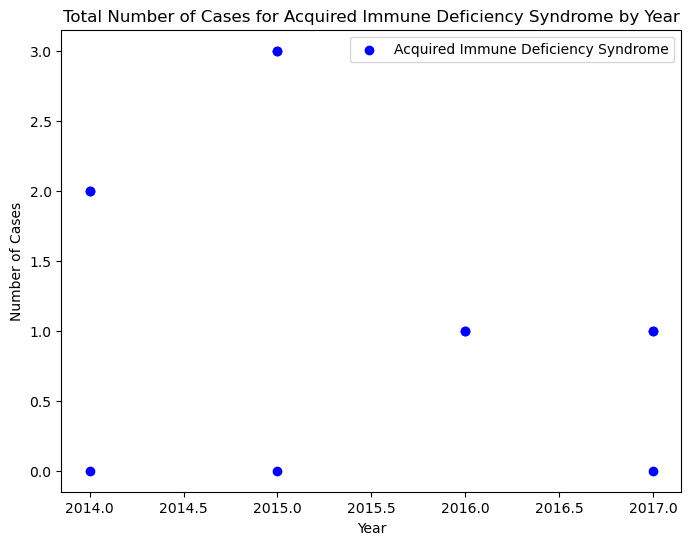

In [55]:
# ---------------------------
# 8. data visualization and transformation
# ---------------------------

diseaseName = 'Acquired Immune Deficiency Syndrome'


disease_data = doc_sex[(doc_sex['Disease'] == diseaseName)]

if disease_data.empty:
    print(f"No data found for disease '{diseaseName}'.")
else:
    plt.figure(figsize=(8, 6))  
    plt.scatter(disease_data['Year'], disease_data['Number of Cases'], color='b', label=diseaseName)
    
    plt.xlabel('Year') 
    plt.ylabel('Number of Cases')  
    plt.title(f"Total Number of Cases for {diseaseName} by Year")  
    
    plt.legend()
    
    plt.show()

## Section 2 - Data imputation, reduction, and basic analysis

The novel coronavirus disease 2019 ([COVID-19](https://www.canada.ca/en/public-health/services/diseases/coronavirus-disease-covid-19.html)) is a contagious disease caused by the severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2). The first known case was identified in December 2019. The disease quickly spread worldwide, resulting in the COVID-19 pandemic. 

In this Section, we will use some simple data science techniques to 1) identify similarities between countries, 2) identify covariates that relate to 

### Dataset: Our World in Data COVID 

The data for this section come [Our World in Data](https://ourworldindata.org/coronavirus), i.e., from their GitHub [repository](https://github.com/owid/covid-19-data/tree/master/public/data). More specifically, the that team aggregated data from multiple sources such as [Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19), various official national sources, the United Nations, the World Bank, Global Burden of Disease, and others. It is released under the [Creative Commons BY License](https://creativecommons.org/licenses/by/4.0/).

There are 67 features in the dataset, only some of which we will use. For information on these, consult https://github.com/owid/covid-19-data/tree/master/public/data.

### Tasks

Our task is to look for simple patterns in the COVID data. First, we will 'fill in the blanks' in the data through imputation, project the data down into fewer dimensions, perform some simple distribution fitting to the data, compute measures of entropy, and finally look for features that are highly related or informative.

Complete each of the code cells below according to the instructions in the comments.

In [58]:
# ---------------------------
# 9. Data Loading, Impute missing data & Preprocessing
# ---------------------------

#Impute mising data
#    - Select only countries with a population >= 30 million
#    - Use the KNNImputer from scikit-learn, with k=3 nearest neighbours, to impute missing
#      numeric data among the selected countries
#    - Your resulting DataFrame should have all text and numeric fields below


import pandas as pd
from sklearn.impute import KNNImputer

urlCOVID = 'https://dal.brightspace.com/d2l/le/dropbox/250788/174362/DownloadAttachment?fid=14594172'
df = pd.read_csv('owid-covid-data.csv')

text_fields = ['location','date']
numeric_fields = ['new_cases_per_million', 'new_deaths_per_million', 
                  'people_vaccinated_per_hundred','people_fully_vaccinated_per_hundred', 
                  'stringency_index', 'population_density', 'median_age', 
                  'gdp_per_capita','extreme_poverty','cardiovasc_death_rate',
                  'hospital_beds_per_thousand','life_expectancy','human_development_index',
                  'population']


df_selected = df[text_fields + numeric_fields].copy()

df_filtered = df_selected[df_selected['population'] >= 30_000_000].copy()

df_filtered.loc[:, numeric_fields] = df_filtered[numeric_fields].astype(float)

df_filtered.loc[:, numeric_fields] = df_filtered[numeric_fields].fillna(df_filtered[numeric_fields].median())

df_filtered



,location,date,new_cases_per_million,new_deaths_per_million,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,stringency_index,population_density,median_age,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,hospital_beds_per_thousand,life_expectancy,human_development_index,population
0,Afghanistan,2020-02-24,0.122,0.212,58.08,52.05,8.33,54.422,18.6,1803.987,2.5,597.029,0.5,64.83,0.511,41128772.0
1,Afghanistan,2020-02-25,0.000,0.212,58.08,52.05,8.33,54.422,18.6,1803.987,2.5,597.029,0.5,64.83,0.511,41128772.0
2,Afghanistan,2020-02-26,0.000,0.212,58.08,52.05,8.33,54.422,18.6,1803.987,2.5,597.029,0.5,64.83,0.511,41128772.0
3,Afghanistan,2020-02-27,0.000,0.212,58.08,52.05,8.33,54.422,18.6,1803.987,2.5,597.029,0.5,64.83,0.511,41128772.0
4,Afghanistan,2020-02-28,0.000,0.212,58.08,52.05,8.33,54.422,18.6,1803.987,2.5,597.029,0.5,64.83,0.511,41128772.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242345,Yemen,2022-12-17,0.000,0.000,58.08,52.05,50.00,53.508,20.3,1479.147,18.8,495.003,0.7,66.12,0.470,33696612.0
242346,Yemen,2022-12-18,0.000,0.000,58.08,52.05,50.00,53.508,20.3,1479.147,18.8,495.003,0.7,66.12,0.470,33696612.0
242347,Yemen,2022-12-19,0.000,0.000,58.08,52.05,50.00,53.508,20.3,1479.147,18.8,495.003,0.7,66.12,0.470,33696612.0
242348,Yemen,2022-12-20,0.000,0.000,58.08,52.05,50.00,53.508,20.3,1479.147,18.8,495.003,0.7,66.12,0.470,33696612.0


In [60]:
# ---------------------------
# 10. Dimensionality Reduction (PCA)
# ---------------------------

from sklearn.decomposition import PCA

# TODO: your code goes here
pca = PCA(n_components=10)
principal_components = pca.fit_transform(df_filtered[numeric_fields])

pca_columns = [f'PC{i+1}' for i in range(10)]
df_pca = pd.DataFrame(principal_components, columns=pca_columns)

df_pca


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,-4.719919e+08,-14192.949583,-33.626506,-115.739609,263.246645,19.786202,-28.947297,-10.999739,-0.889745,-5.413945
1,-4.719919e+08,-14192.950402,-33.748387,-115.735481,263.243620,19.787588,-28.947107,-10.999988,-0.889608,-5.413753
2,-4.719919e+08,-14192.950402,-33.748387,-115.735481,263.243620,19.787588,-28.947107,-10.999988,-0.889608,-5.413753
3,-4.719919e+08,-14192.950402,-33.748387,-115.735481,263.243620,19.787588,-28.947107,-10.999988,-0.889608,-5.413753
4,-4.719919e+08,-14192.950402,-33.748387,-115.735481,263.243620,19.787588,-28.947107,-10.999988,-0.889608,-5.413753
...,...,...,...,...,...,...,...,...,...,...
64561,-4.794241e+08,-14521.948162,-28.849193,-106.756373,158.920715,6.824294,5.664905,8.302943,-0.363873,-0.574184
64562,-4.794241e+08,-14521.948162,-28.849193,-106.756373,158.920715,6.824294,5.664905,8.302943,-0.363873,-0.574184
64563,-4.794241e+08,-14521.948162,-28.849193,-106.756373,158.920715,6.824294,5.664905,8.302943,-0.363873,-0.574184
64564,-4.794241e+08,-14521.948162,-28.849193,-106.756373,158.920715,6.824294,5.664905,8.302943,-0.363873,-0.574184



Analyzing distribution for: new_cases_per_million


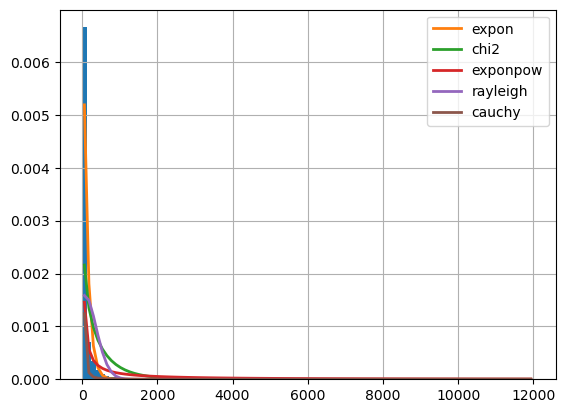

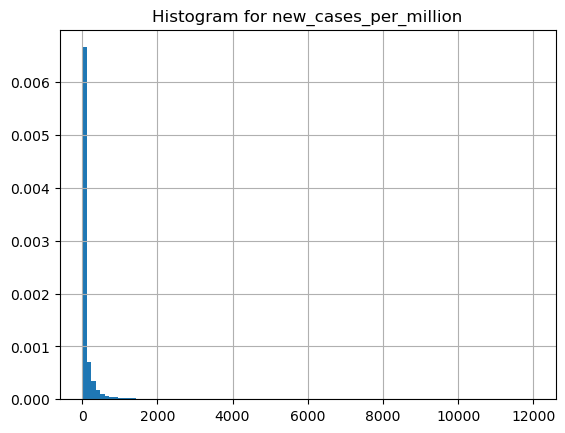

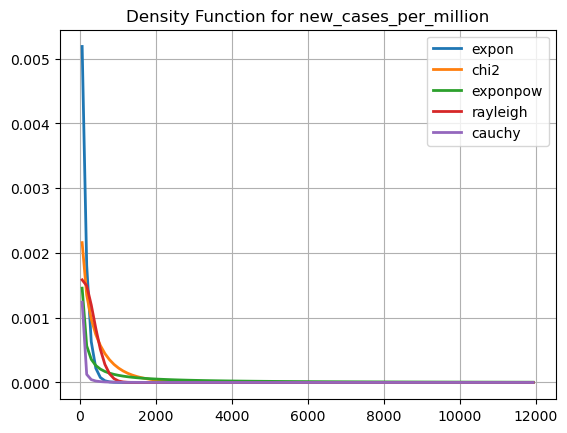


Analyzing distribution for: new_deaths_per_million


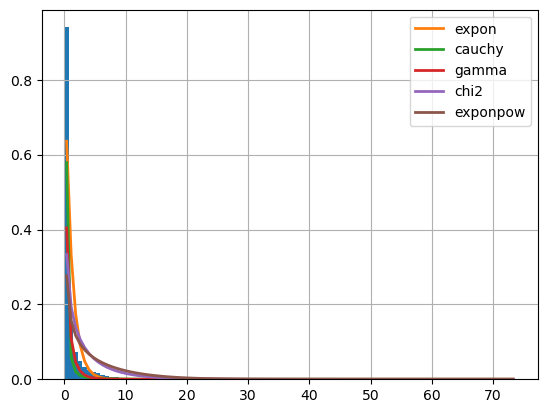

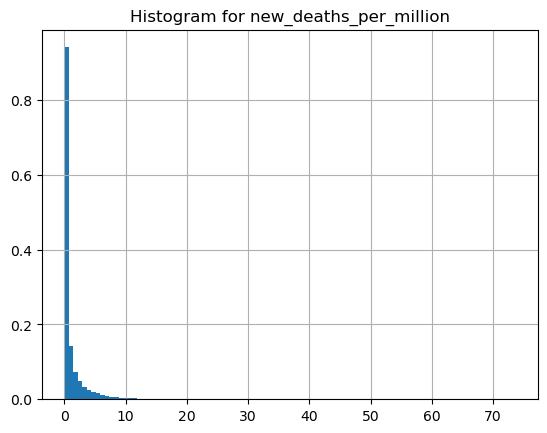

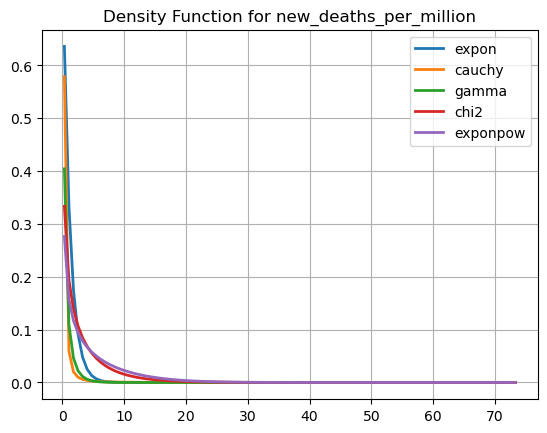


Analyzing distribution for: people_vaccinated_per_hundred


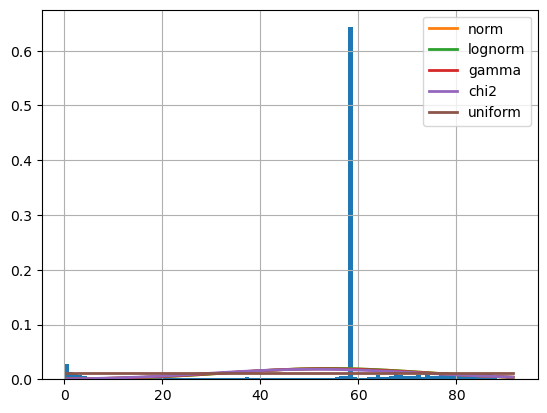

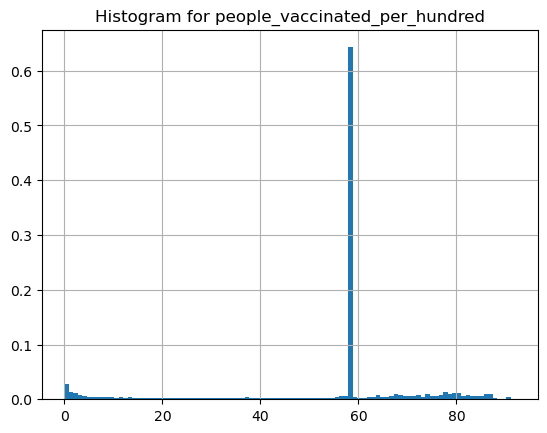

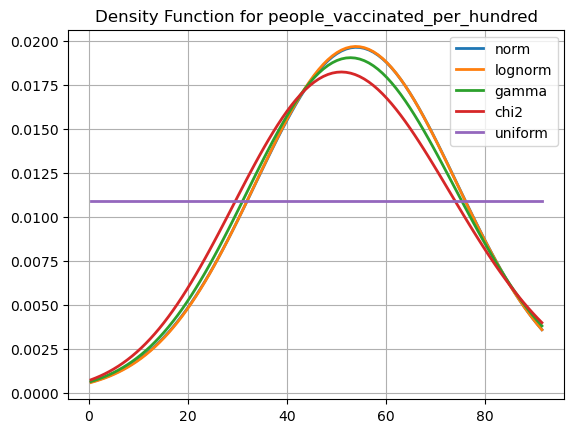


Analyzing distribution for: people_fully_vaccinated_per_hundred


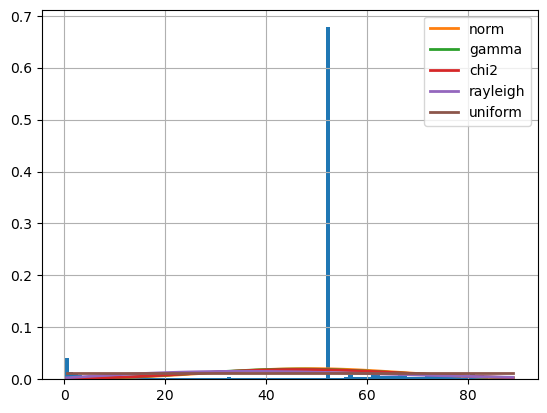

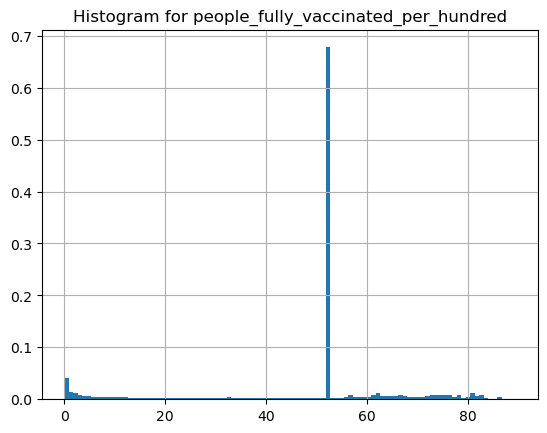

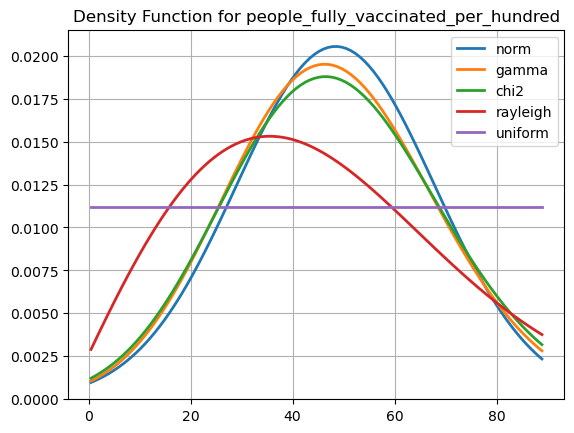


Analyzing distribution for: stringency_index


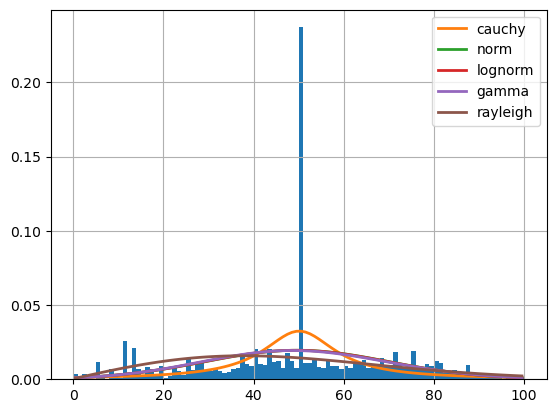

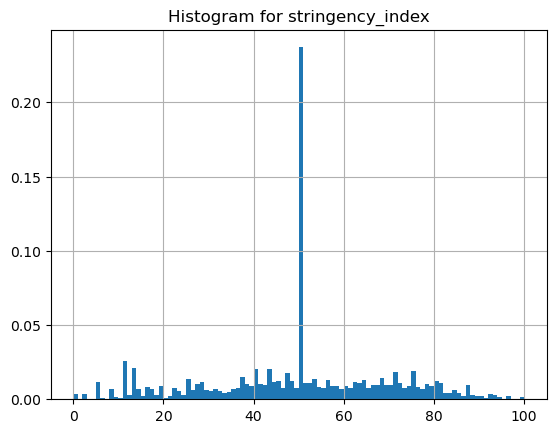

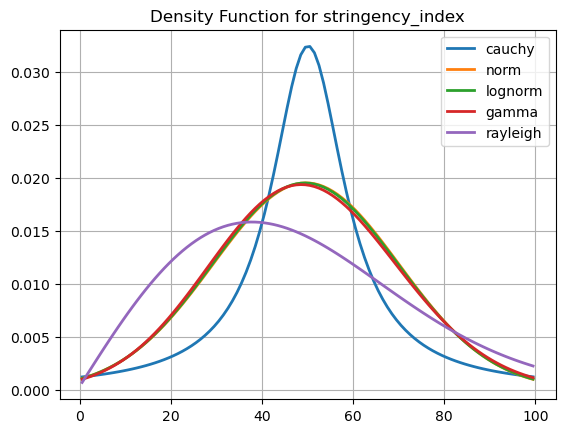


Analyzing distribution for: population_density


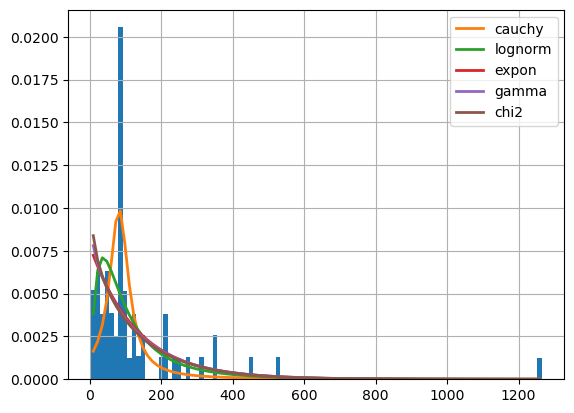

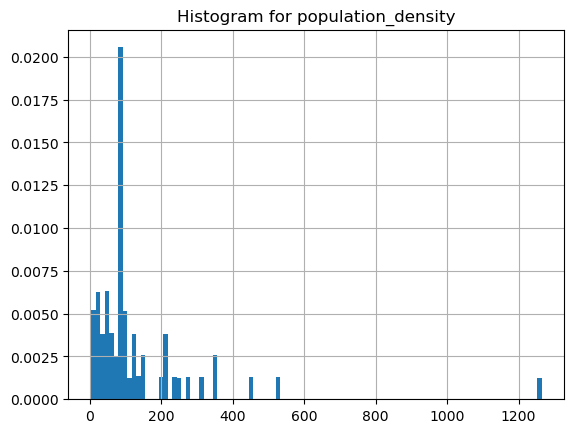

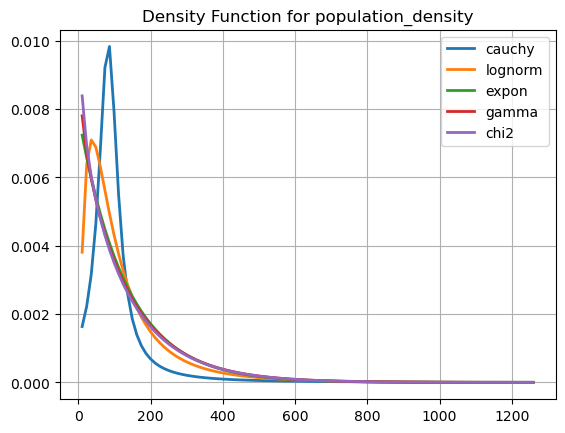


Analyzing distribution for: median_age


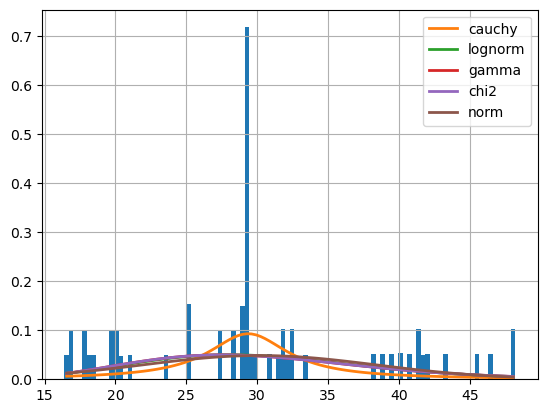

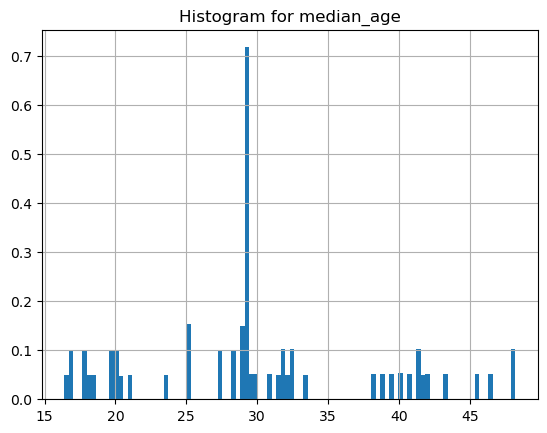

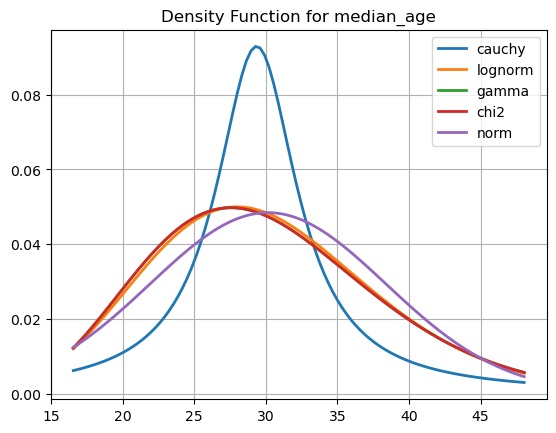


Analyzing distribution for: gdp_per_capita


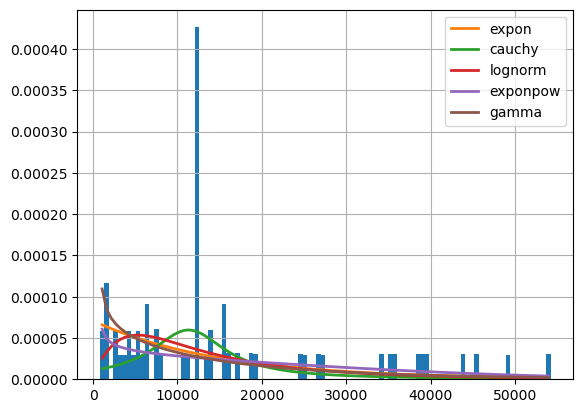

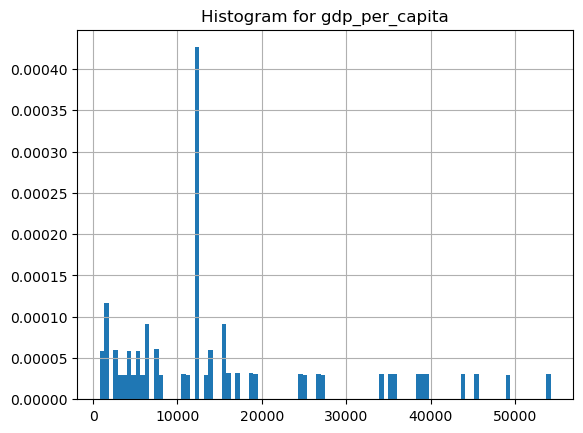

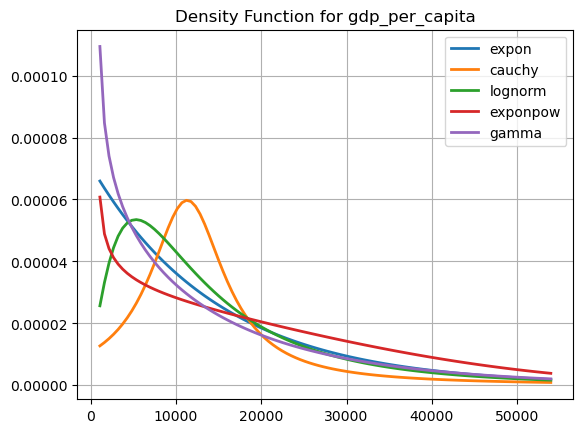


Analyzing distribution for: extreme_poverty


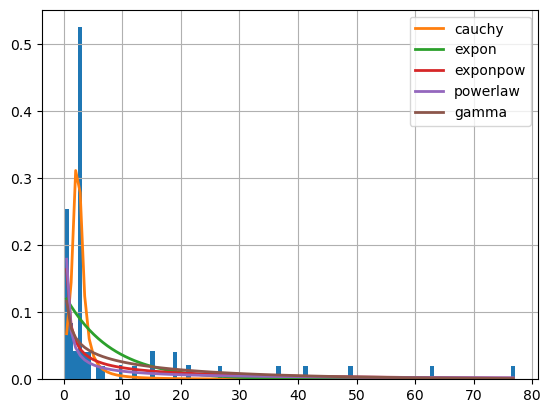

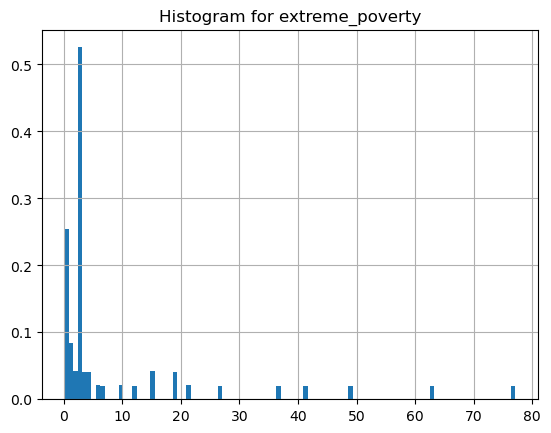

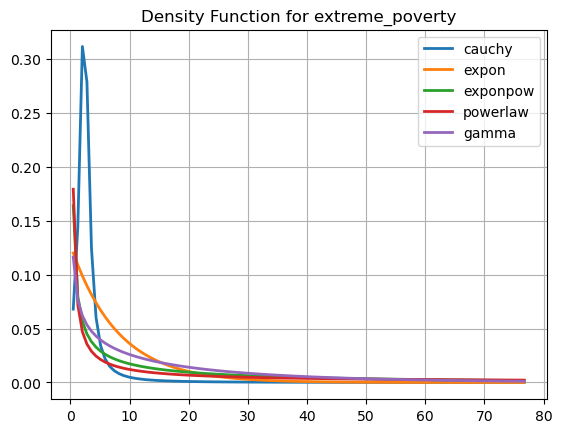


Analyzing distribution for: cardiovasc_death_rate


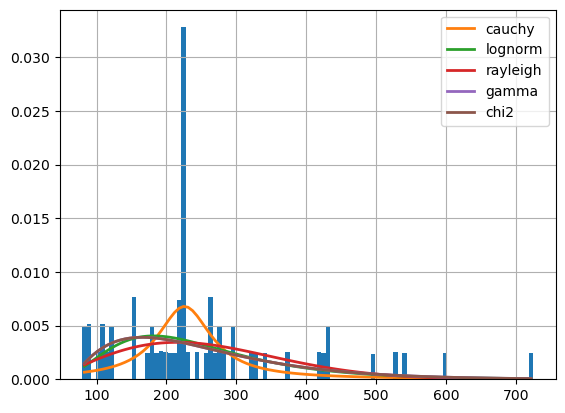

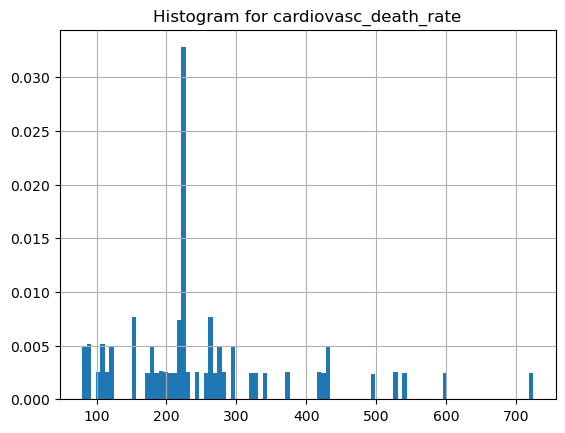

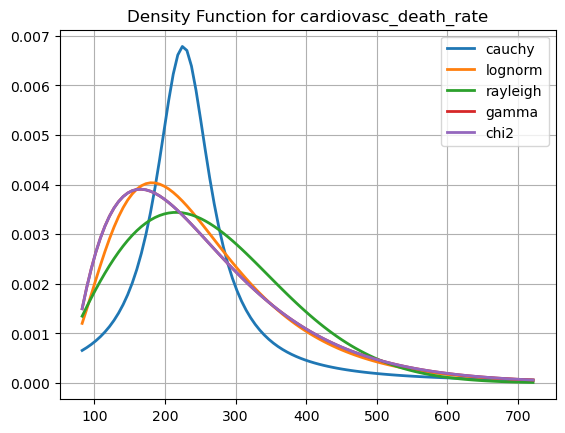


Analyzing distribution for: hospital_beds_per_thousand


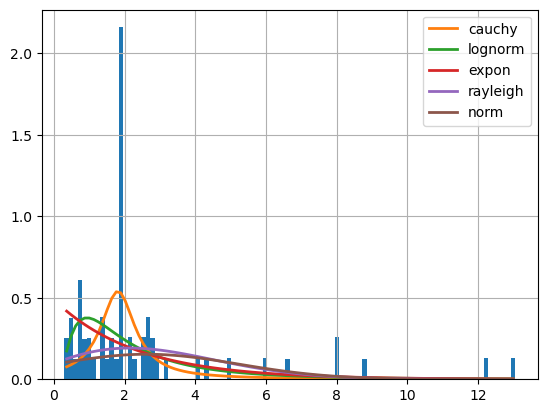

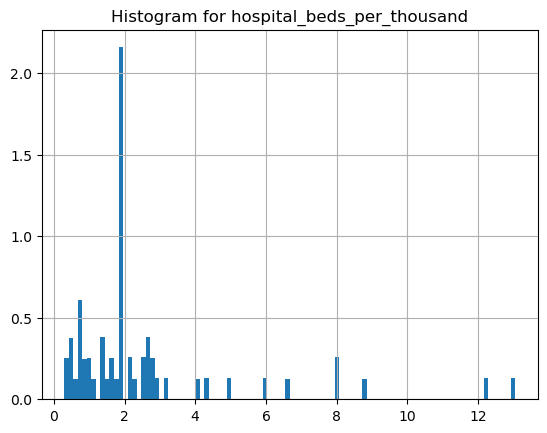

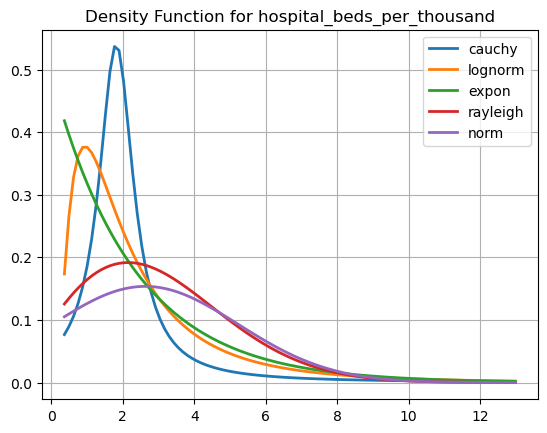


Analyzing distribution for: life_expectancy


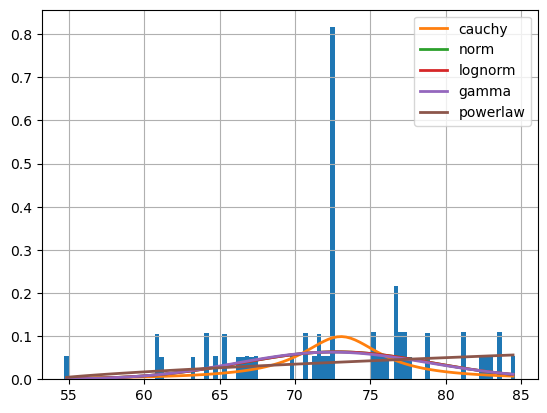

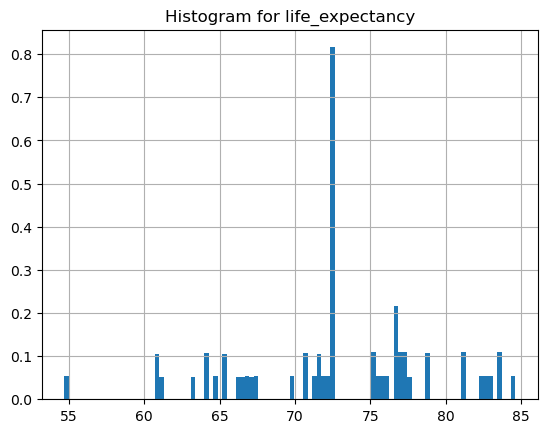

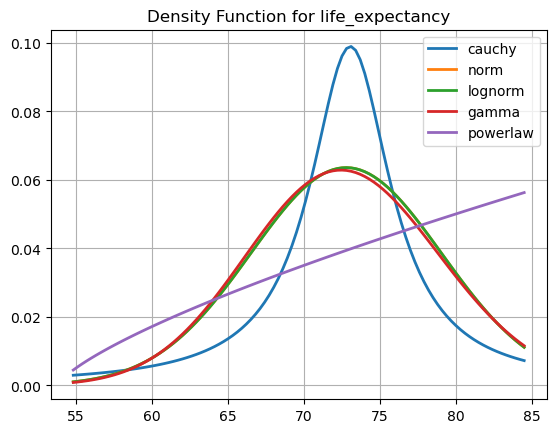


Analyzing distribution for: human_development_index


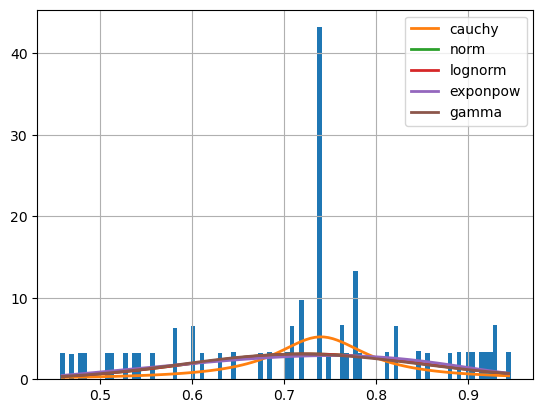

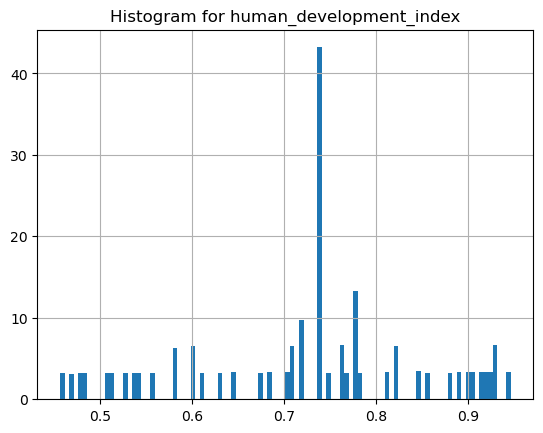

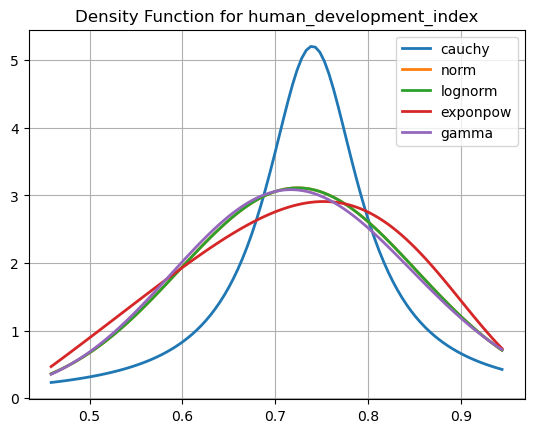


Analyzing distribution for: population


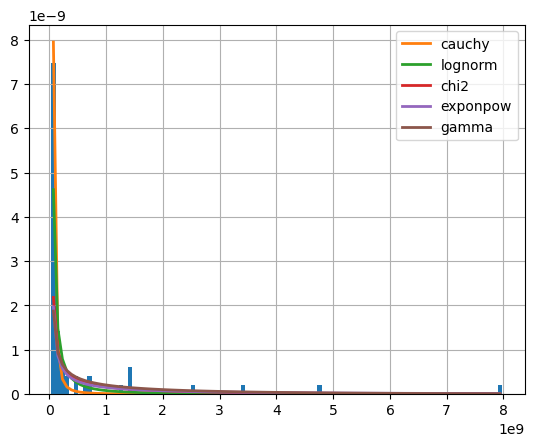

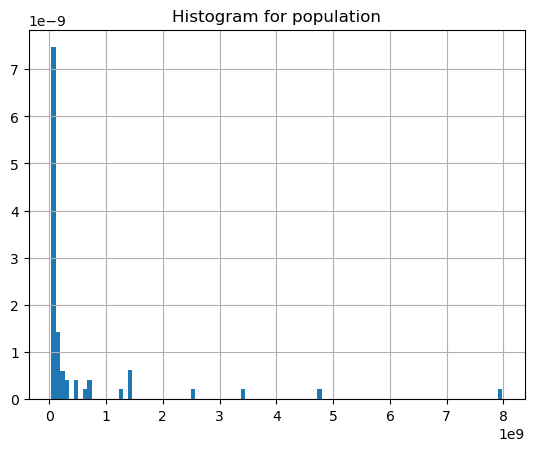

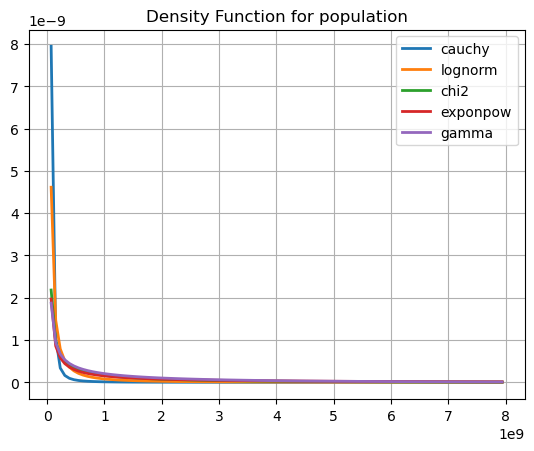

In [62]:
# ---------------------------
# 11. Distribution Fitting
# --------------------------

from fitter import Fitter, get_common_distributions

common_distributions = get_common_distributions()
# TODO: your code goes here

for field in df_filtered.select_dtypes(include=['number']).columns:
    print(f"\nAnalyzing distribution for: {field}")
    
    data = df_filtered[field].dropna()

    fitter = Fitter(data, distributions=common_distributions)
    fitter.fit()

    fitter.summary()

    plt.figure()
    fitter.hist()
    plt.title(f"Histogram for {field}")

    plt.figure()
    fitter.plot_pdf()
    plt.title(f"Density Function for {field}")

    plt.show()



In [63]:
# ---------------------------
# 12. Entropy Calculation
# ---------------------------

from scipy import stats
from scipy.stats import entropy

# TODO: your code goes here

#    discretize data in two methods - equal probability vs equal size.
#    compute entropy.
p_equalWidth = np.zeros(100)
p_equalFreq  = np.zeros(100)

# TODO: your code goes here
for field in df_filtered.select_dtypes(include=['number']).columns:
    print(f"\nAnalyzing distribution for: {field}")
    
    data = df_filtered[field].dropna()

    fitter = Fitter(data, distributions=common_distributions)
    fitter.fit()

    best_distribution, best_params = list(fitter.get_best().items())[0]

    print(f"Best distribution: {best_distribution}")
    print(f"Best parameters: {best_params}")

    dist_class = getattr(stats, best_distribution)
    
    if isinstance(best_params, tuple):
        entropy_value = dist_class.entropy(*best_params)
    else:
        entropy_value = dist_class.entropy(best_params)

    print(f"Entropy for {best_distribution} distribution: {entropy_value}")

    bins_equal_width = np.linspace(data.min(), data.max(), 101)
    bins_equal_freq = np.percentile(data, np.linspace(0, 100, 101))

    _, counts_width = np.histogram(data, bins=bins_equal_width)
    p_equalWidth = counts_width / len(data)

    _, counts_freq = np.histogram(data, bins=bins_equal_freq)
    p_equalFreq = counts_freq / len(data)

    entropy_width = stats.entropy(p_equalWidth)
    entropy_freq = stats.entropy(p_equalFreq)
    
    print(f"Shannon Entropy (Equal Width) for {field}: {entropy_width}")
    print(f"Shannon Entropy (Equal Frequency) for {field}: {entropy_freq}")
    
    


Analyzing distribution for: new_cases_per_million
Best distribution: expon
Best parameters: {'loc': 0.0, 'scale': 113.78538630238823}
Entropy for expon distribution: 1.0
Shannon Entropy (Equal Width) for new_cases_per_million: 4.416897589984665
Shannon Entropy (Equal Frequency) for new_cases_per_million: 2.1342942147337864

Analyzing distribution for: new_deaths_per_million
Best distribution: expon
Best parameters: {'loc': 0.0, 'scale': 1.1380268097760433}
Entropy for expon distribution: 1.0
Shannon Entropy (Equal Width) for new_deaths_per_million: 4.416897589984663
Shannon Entropy (Equal Frequency) for new_deaths_per_million: 2.707983535636723

Analyzing distribution for: people_vaccinated_per_hundred
Best distribution: norm
Best parameters: {'loc': 54.05937397391817, 'scale': 20.3259972268001}
Entropy for norm distribution: 1.4189385332046727
Shannon Entropy (Equal Width) for people_vaccinated_per_hundred: 4.416897589984664
Shannon Entropy (Equal Frequency) for people_vaccinated_per

Correlation with 'new_cases_per_million':
new_deaths_per_million                 0.306425
people_vaccinated_per_hundred          0.153434
people_fully_vaccinated_per_hundred    0.172594
stringency_index                      -0.036896
population_density                     0.035014
median_age                             0.265241
gdp_per_capita                         0.257129
extreme_poverty                       -0.125176
cardiovasc_death_rate                 -0.186030
hospital_beds_per_thousand             0.218658
life_expectancy                        0.253288
human_development_index                0.267593
population                            -0.039099
Name: new_cases_per_million, dtype: float64

Correlation with 'new_deaths_per_million':
new_cases_per_million                  0.306425
people_vaccinated_per_hundred         -0.201006
people_fully_vaccinated_per_hundred   -0.202422
stringency_index                       0.239017
population_density                    -0.095091
median

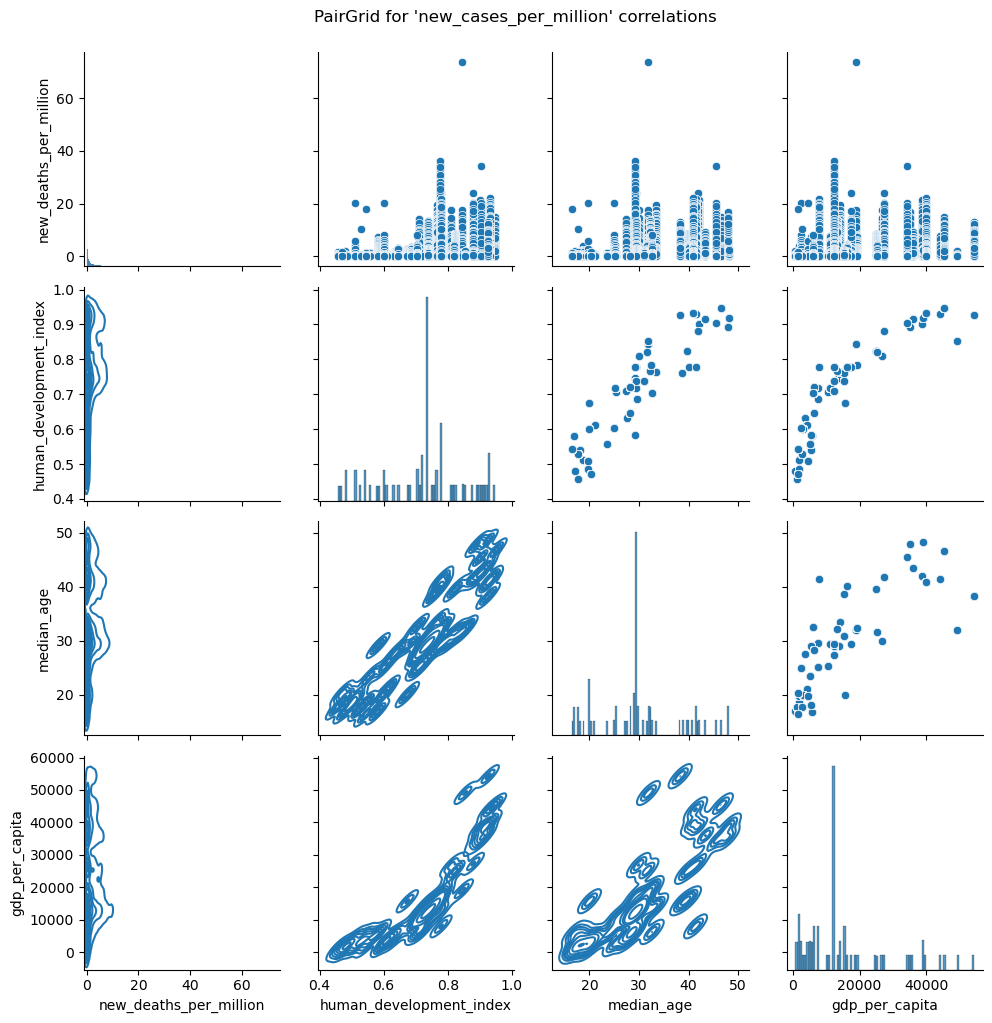

In [ ]:
# ------------------------------------------
# 13. Correlation Analysis and Visualization
# ------------------------------------------

import seaborn as sns

df_filtered = df_filtered.dropna(subset=['new_cases_per_million', 'new_deaths_per_million'])

df_numeric = df_filtered[numeric_fields]

# Calculate the Pearson correlation for 'new_cases_per_million' and 'new_deaths_per_million' with all numeric fields
correlation_cases = df_numeric.corr()['new_cases_per_million'].drop('new_cases_per_million')
correlation_deaths = df_numeric.corr()['new_deaths_per_million'].drop('new_deaths_per_million')

# Check if we got the correlations
print("Correlation with 'new_cases_per_million':")
print(correlation_cases)

print("\nCorrelation with 'new_deaths_per_million':")
print(correlation_deaths)

# Get the 4 most correlated features with 'new_cases_per_million' and 'new_deaths_per_million'
top_4_cases = correlation_cases.abs().nlargest(4).index
top_4_deaths = correlation_deaths.abs().nlargest(4).index

# Check the most correlated features
print("\nTop 4 most correlated features with 'new_cases_per_million':")
print(top_4_cases)

print("\nTop 4 most correlated features with 'new_deaths_per_million':")
print(top_4_deaths)

# Plot PairGrid for the 4 most correlated features with 'new_cases_per_million'
g_cases = sns.PairGrid(df_numeric[top_4_cases], diag_sharey=False)
g_cases.map_upper(sns.scatterplot)
g_cases.map_lower(sns.kdeplot)
g_cases.map_diag(sns.histplot)
plt.suptitle("PairGrid for 'new_cases_per_million' correlations", y=1.02)
plt.show()

# Plot PairGrid for the 4 most correlated features with 'new_deaths_per_million'
g_deaths = sns.PairGrid(df_numeric[top_4_deaths], diag_sharey=False)
g_deaths.map_upper(sns.scatterplot)
g_deaths.map_lower(sns.kdeplot)
g_deaths.map_diag(sns.histplot)
plt.suptitle("PairGrid for 'new_deaths_per_million' correlations", y=1.02)
plt.show()


The features most correlated with 'new_cases_per_million' and 'new_deaths_per_million' were determined by calculating the Pearson correlation of all numeric fields. The next step was to visualize the top correlated features in a PairGrid plot to see how they correlated to each other as well. The features most correlated with the output variable are not necessarily the same identified as 'informative' in Task 4 because tasks 4 and 5 target / attribute different properties of the data; while task 4 is based on the data variability (entropy), task 5 is based on how strongly the input variables are linearly related to one another. Due to high correlation, some features can have low variability and still have a strong relationship with the outcome. So for linear relationships, correlation is a useful metric but entropy explains the proportion and variations in the data.

**Conclusion**
This project demonstrates:
1. **Robust Data Engineering**:
- Handled real-world data quality issues (missing values, duplicates, range errors)
- Implemented comprehensive validation checks
2. **Advanced Analytics**:
- Applied PCA for dimensionality reduction
- Performed statistical distribution fitting
- Calculated entropy for feature analysis
- Data tranformation and visualization
3. **Actionable Insights**:
- Identified key relationships in COVID-19 data
- Generated visualizations for technical and non-technical audiences

**Key Learnings**: Real-world data requires sophisticated cleaning approaches before analysis. COVID-19 patterns reveal strong relationships between socioeconomic factors and pandemic outcomes.

---
**Note**: The full code with outputs is available in the accompanying Jupyter Notebook